In autoencoder, it was seen that the model was trying to learn the distribution of the data explicitly which is later used for generating the images/data. On the other hand GAN learns to generate the data starting from a vector sampled from a gaussian distribution but generally doesn't try to learn the distribution of data.

GAN (Generative adversarial network) uses two network which are made to compete against each other. One of the network is called Generator and the other is called discriminator. The game in which they are made to compete is as follows:

- Generator tries to generate the data using a vector sampled from gaussian distribution.
- Discriminator tries to detect whether the sample it received is fake sample from generator or the real sample from data.
- They are made to compete against each other where the generator tries to fool the discriminator whereas the discriminator tries to detect fake samples by avoiding being fooled by generator (like art forgerer trying to generate fake art and an art appraiser trying to detect the fake art from the real one)

__NOTE:__ This notebook explores implementing dcgan on celeba dataset.

Dataset Reference: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

      @inproceedings{liu2015faceattributes,

      title = {Deep Learning Face Attributes in the Wild},

      author = {Liu, Ziwei and Luo, Ping and Wang, Xiaogang and Tang, Xiaoou},

      booktitle = {Proceedings of International Conference on Computer Vision (ICCV)},

      month = {December},

      year = {2015} 
      
      }

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchsummary import summary
from PIL import Image
import pandas as pd
import pathlib
import wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Helper Functions

In [2]:
def save_checkpoint(model, save_path):
    torch.save(model.state_dict(), save_path)
    
def load_checkpoint(model, save_path):
    model.load_state_dict(torch.load(save_path))
    return model

def visualization(model, title, latent_dim, inv_transform, clear = True):
    model.eval()
    fig_1, axes_1 = plt.subplots(nrows = 10, ncols = 10, figsize = (6,6))
    with torch.no_grad():
        latent_vec = torch.randn(100, latent_dim).to(device)
        imgs = inv_transform(model(latent_vec))
        for idx in tqdm(range(100), leave = False):
            img = np.transpose(imgs[idx].detach().cpu().numpy(), (1,2,0))
            axes_1[idx//10, idx%10].imshow(img)
            axes_1[idx//10, idx%10].axis('off')
    wandb.log({f"{title}_regenerated":fig_1})
    if clear:
        fig_1.clear()
        plt.close(fig_1)

# Hyperparameters

In [3]:
batch_size = 64
input_vector_channel = 3
img_resize = 64
img_crop_size = 64
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# Setting experiment
wandb.init(dir = 'logs/', project='GAN Projects', name="DCGAN (CELEBA)")
num_filters = [512, 256, 128, 64]
latent_dim = 100
filter_size = 4
strides = [2, 2, 2, 2]
learning_rate = 0.0002
beta1 = 0.5 # Adam Optimizer param
num_epochs = 100
criterion = nn.BCEWithLogitsLoss()
valid_size = 0
gen_save_path = './saved_models/generator_dcgan.pt'
dis_save_path = './saved_models/discriminator_dcgan.pt'

wandb.config = {
    'batch_size': batch_size,
    'num_filters': num_filters,
    'latent_dim': latent_dim,
    'image_size': img_crop_size,
    'valid_size': valid_size,
    'filter_size': filter_size,
    'beta1 (for adam)': beta1,
    'strides': strides,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'initializer': 'uniform',
    'loss': 'bce_logits'
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aniketthomas. Use `wandb login --relogin` to force relogin


# Loading and preprocessing data

In [4]:
class CelebADataset(Dataset):
    def __init__(self, images_path, transforms = None):
        self.images_path = images_path
        self.transforms = transforms
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self, idx):
        img_path = self.images_path[idx]
        img = Image.open(str(img_path))
        fname = img_path.name
        if self.transforms:
            img = self.transforms(img)
        return img, fname

In [5]:
base_path = pathlib.Path('data/celeba/')
imgs_dir = base_path/'images/images'
all_images = list(imgs_dir.glob('./*.png'))
num_valid = int(valid_size*len(all_images))
train_imgs = all_images[num_valid:]
valid_imgs = all_images[:num_valid]
print(f'Total Number of Images: {len(all_images)}')
print(f'Total Number of Train Images: {len(train_imgs)}')
print(f'Total Number of Valid Images: {len(valid_imgs)}')

Total Number of Images: 202599
Total Number of Train Images: 202599
Total Number of Valid Images: 0


In [6]:
transform = transforms.Compose([transforms.Resize(img_resize),
                                transforms.RandomCrop(img_crop_size, pad_if_needed=True),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
inv_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                        std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                                      transforms.Normalize(mean = [-mean[0], -mean[1], -mean[2]],
                                         std = [ 1., 1., 1. ])])
train_dataset = CelebADataset(train_imgs,transforms = transform)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=8, pin_memory=True)

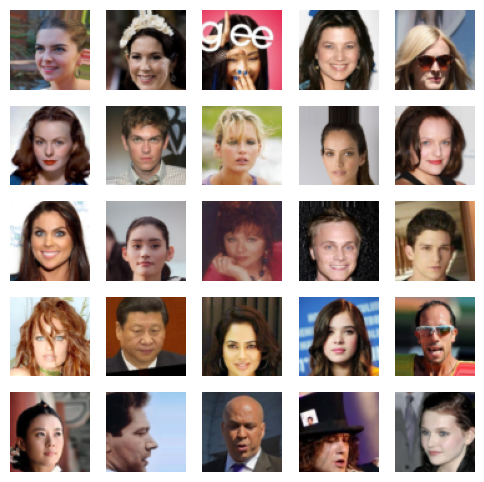

In [7]:
# Visualizing Data
imgs, _ = next(iter(trainloader))
imgs = inv_transform(imgs)
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize = (6,6))
i = 0
for idx in range(rows*cols):
    img = np.transpose(imgs[idx].detach().cpu().numpy(), (1, 2, 0))
    axes[i//rows, i%cols].imshow(img)
    axes[i//rows, i%cols].axis('off')
    i+=1

# Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, input_vector_channel, num_filters, latent_dim, strides):
        super(Generator, self).__init__()

        layer_list = []
        self.inp_dim = input_vector_channel[0]
        all_units = num_filters + input_vector_channel
        kernel_size = 4

        layer_list.extend([nn.ConvTranspose2d(latent_dim, all_units[0], kernel_size, 1, 0, bias = False),
                        nn.BatchNorm2d(all_units[0]),
                        nn.ReLU(inplace=True)])
        for i in range(len(all_units) - 2):
            temp = [nn.ConvTranspose2d(all_units[i], all_units[i+1], kernel_size, strides[i], padding=1, bias=False),
                    nn.BatchNorm2d(all_units[i+1]),
                    nn.ReLU(inplace = True)]
            layer_list.extend(temp)
        layer_list.extend([nn.ConvTranspose2d(all_units[i+1], all_units[i+2], kernel_size, strides[i+1], padding=1, bias = False),
                         nn.Tanh()])
        
        self.generator = nn.Sequential(*layer_list)
        # Initialize weights
        self.generator.apply(self.init_weights)

    def init_weights(self, layer):
        # Weight initialization paramters taken from DC GAN original paper by Alec Radford
        if isinstance(layer, nn.ConvTranspose2d):
            nn.init.normal_(layer.weight.data, 0.0, 0.02)
        if isinstance(layer, nn.BatchNorm2d):
            nn.init.normal_(layer.weight.data, 1.0, 0.02)
            nn.init.constant_(layer.bias.data, 0)


    def forward(self, x):
        x = x.view(x.shape[0], x.shape[-1],1,1)
        out = self.generator(x)
        return out
generator = Generator([input_vector_channel], num_filters, latent_dim, strides)
summary(generator, (latent_dim,));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 64, 32, 32]          131,072
|    └─BatchNorm2d: 2-11                 [-1, 64, 32, 32]          128
|    └─ReLU: 2-12                        [-1, 64, 32, 32]

# Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_vector_channel, num_filters, latent_dim, strides, leaky_relu_slope = 0.2):
        super(Discriminator, self).__init__()
        layer_list = []
        self.inp_dim = input_vector_channel[0]
        all_units = num_filters + input_vector_channel
        kernel_size = 4

        layer_list.extend([nn.Conv2d(all_units[-1], all_units[-2], kernel_size, strides[-1], 1, bias = False),
                        nn.LeakyReLU(leaky_relu_slope, inplace=True)])
        for i in range(len(all_units) - 2, 0, -1):
            temp = [nn.Conv2d(all_units[i], all_units[i-1], kernel_size, strides[i-1], padding=1, bias=False),
                    nn.BatchNorm2d(all_units[i-1]),
                    nn.LeakyReLU(leaky_relu_slope, inplace = True)]
            layer_list.extend(temp)
        layer_list.extend([nn.Conv2d(all_units[i-1], 1, kernel_size, 1, 0, bias = False)])
        
        self.discriminator = nn.Sequential(*layer_list)
        # Initialize weights
        self.discriminator.apply(self.init_weights)

    def init_weights(self, layer):
        # Weight initialization paramters taken from DC GAN original paper by Alec Radford
        if isinstance(layer, nn.Conv2d):
            nn.init.normal_(layer.weight.data, 0.0, 0.02)
        if isinstance(layer, nn.BatchNorm2d):
            nn.init.normal_(layer.weight.data, 1.0, 0.02)
            nn.init.constant_(layer.bias.data, 0)


    def forward(self, x):
        out = self.discriminator(x)
        return out
discriminator = Discriminator([input_vector_channel], num_filters, latent_dim, strides)
summary(discriminator, (3,64,64));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 4, 4]           --
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]      

In [10]:
visualization(generator, "Pre_Train", latent_dim = latent_dim, inv_transform = inv_transform, clear = True);

# Training Autoencoder



In [11]:
def train_discriminator(imgs, discriminator, criterion, optimizer, scaler, label):
    optimizer.zero_grad()
    imgs, discriminator = imgs.to(device, non_blocking = True), discriminator.to(device)
    labels = torch.full((len(imgs),), label, dtype=torch.float).to(device)
    with torch.cuda.amp.autocast():
        out = discriminator(imgs).view(-1)
        batch_loss = criterion(out, labels)
    scaler.scale(batch_loss).backward()
    scaler.step(optimizer)
    scaler.update()
    return batch_loss.item()

def train(trainloader, generator, discriminator, criterion, g_opt, d_opt, num_epochs, load_check = False, 
          latent_dim = latent_dim, generator_save = './saved_models/gen.pt', disc_save = './saved_models/disc.pt'):    
    # Load From checkpoint
    if load_check:
        discriminator = load_checkpoint(discriminator, disc_save)
        generator = load_checkpoint(generator, generator_save)

    scaler = torch.cuda.amp.GradScaler()
    generator_losses, discriminator_losses = [], []
    fake_label, real_label = 0, 1
    iteration = 0
    generator, discriminator = generator.to(device), discriminator.to(device)
    for epoch in range(num_epochs+1):
        current_disc_loss = 0.0
        current_gen_loss = 0.0
        discriminator.train()
        generator.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, _ in pbar:

            # Training Discriminator
            d_opt.zero_grad()
            imgs = imgs.to(torch.float32)
            current_real_loss = train_discriminator(imgs, discriminator, criterion, d_opt, scaler, real_label)


            fake_samples = torch.randn((len(imgs), latent_dim)).to(device)
            fake_imgs = generator(fake_samples)
            current_fake_loss = train_discriminator(fake_imgs.detach(), discriminator, criterion, d_opt, scaler, fake_label)

            current_disc_loss += (current_real_loss + current_fake_loss)/2.

            # Training Generator
            g_opt.zero_grad()
            labels = torch.full((len(fake_imgs), ), real_label, dtype = torch.float).to(device)
            with torch.cuda.amp.autocast():
                out = discriminator(fake_imgs).view(-1)
                g_loss = criterion(out, labels)
            scaler.scale(g_loss).backward()
            scaler.step(g_opt)
            scaler.update()

            current_gen_loss += g_loss
            pbar.set_postfix(disc_loss = (current_real_loss + current_fake_loss)/2.0, gen_loss = g_loss.item())
            wandb.log({'iterations': iteration, 'disc_loss': (current_real_loss + current_fake_loss)/2.0, 'gen_loss': g_loss.item()})
            iteration+=1

        current_disc_loss /= len(trainloader)
        current_gen_loss /= len(trainloader)
        generator_losses.append(current_gen_loss)
        discriminator_losses.append(current_disc_loss)
        if epoch % 5 == 0:
            wandb.log({'epoch':epoch ,'generator_losses': current_gen_loss, 'discriminator_losses': current_disc_loss})
            visualization(generator, "Epoch_train", latent_dim = latent_dim, inv_transform = inv_transform)
            print(f"{'*'*10} EPOCH {epoch:2}/{num_epochs} {'*'*10}")
            print(f'''{"#"*33}
Discriminator Loss: {current_disc_loss:5.3f}
Generator Loss: {current_gen_loss:5.3f}
{"#"*33}''')
            save_checkpoint(discriminator, disc_save)
            save_checkpoint(generator, generator_save)
    return generator_losses, discriminator_losses

In [12]:
g_opt = optim.Adam(generator.parameters(), learning_rate, (beta1, 0.999))
d_opt = optim.Adam(discriminator.parameters(), learning_rate, (beta1, 0.999))
generator_losses, discriminator_losses = train(trainloader, generator, discriminator, criterion, g_opt, d_opt, num_epochs, 
                                               False, latent_dim, gen_save_path, dis_save_path)

********** EPOCH  0/100 **********
#################################
Discriminator Loss: 0.245
Generator Loss: 6.418
#################################


 10%|█         | 328/3166 [00:37<03:46, 12.55it/s, disc_loss=0.273, gen_loss=5.37] 

In [ ]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(generator_losses, 'r--', label = 'Generator Loss')
plt.plot(discriminator_losses, 'g-', label = 'Discriminator Loss')
plt.legend()
plt.show();

In [ ]:
generator = load_checkpoint(generator, gen_save_path)
visualization(generator, "Epoch_train", latent_dim = latent_dim, inv_transform = inv_transform, clear = False)